In [1]:
import h5py
import librosa
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.signal
import soundfile as sf
import sys
sys.path.append('../src')
import localmodule

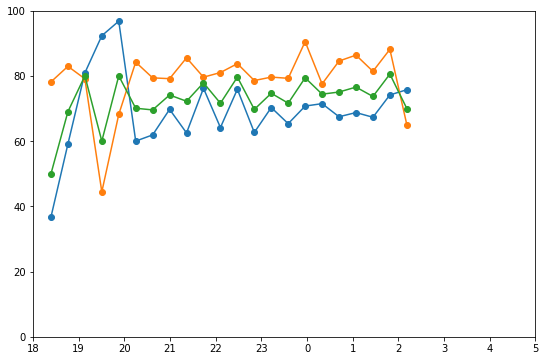

In [67]:
# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
trials = [7, 7, 2, 0, 3, 3] # maximize clip-wise val acc
icassp_thresholds = 1.0 - np.concatenate((
    np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
))
n_thresholds = len(icassp_thresholds)
tolerance = 0.5 # in seconds


# Define directory for model.
aug_str = "all"
model_name = "icassp-convnet"
if not aug_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_str])
model_dir = os.path.join(models_dir, model_name)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


# Pick the highest threshold.
threshold = icassp_thresholds[120]


# Loop over units.
for test_unit_id in range(n_units):

    # Load prediction.
    test_unit_str = units[test_unit_id]
    unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = trials[test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(unit_dir, trial_str)
    prediction_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-predictions.csv"])
    prediction_path = os.path.join(trial_dir, prediction_name)
    prediction_df = pd.read_csv(prediction_path)
    odf = np.array(prediction_df["Predicted probability"])
    timestamps = np.array(prediction_df["Timestamp"])


    # Select peaks.
    peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
    selected = timestamps[peak_locations]


    # Load annotation.
    annotation_path = os.path.join(annotations_dir,
        test_unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)


    # Match events.
    selected_relevant = mir_eval.util.match_events(
        relevant, selected, tolerance)
    tp_relevant_ids = list(zip(*selected_relevant))[0]
    tp_relevant_times = [relevant[i] for i in tp_relevant_ids]
    tp_selected_ids = list(zip(*selected_relevant))[1]
    tp_selected_times = [selected[i] for i in tp_selected_ids]


    # List false alarms
    fp_times = [selected[i] for i in range(len(selected))
        if i not in tp_selected_ids]


    # List missed detections
    fn_times = [relevant[i] for i in range(len(relevant))
        if i not in tp_relevant_ids]

from matplotlib import pyplot as plt
%matplotlib inline

n_bins = 22;

tp_x, tp_y = np.histogram(tp_relevant_times, bins=n_bins);
fp_x, fp_y = np.histogram(fp_times, bins=n_bins);
fn_x, fn_y = np.histogram(fn_times, bins=n_bins);

P = tp_x / (tp_x + fp_x + np.finfo(float).eps)
R = tp_x / (tp_x + fn_x + np.finfo(float).eps)
F = (2*P*R) / (P + R + np.finfo(float).eps)

total_P = len(tp_relevant_times) / (len(tp_relevant_times) + len(fp_times))
total_R = len(tp_relevant_times) / (len(tp_relevant_times) + len(fn_times))
total_F = 2 * total_P * total_R / (total_P + total_R)

plt.figure(figsize=(9,6))
plt.plot(tp_y[1:] / 3600, 100 * P[:] , '-o')
plt.plot(tp_y[1:] / 3600, 100 * R[:] , '-o')
plt.plot(tp_y[1:] / 3600, 100 * F[:], '-o')
plt.ylim(0, 100)
plt.xticks(range(12), [str(np.mod(n, 24)) for n in range(-6, 6)]);

In [68]:
total_F

0.7208645288882609